In [1]:
from scipy.integrate import ode
from scipy.interpolate import interp1d
import pandas as pd
from astropy import units as u
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from scipy.optimize import minimize, approx_fprime
from joblib import Parallel, delayed

Capture hides output

In [2]:
%%capture
%run cowling_approximation8.ipynb

In [3]:
def process(k):
    df = pd.read_csv(path)
    e, p = df_to_ep(df)
    EOS = get_ep(e, p)
    
    km2cm, r_i, p0, e0, p_c, e_c, m0, omega, l, \
    v0, W0, U0, init_VEC = initial_conditions(EOS, e, p, k = k)
    
    # Integrate
    p, m, r_arr, v, w, u = tov(EOS, init_VEC, r_i, p_min, p_max, omega, l = l)

    max_idx, m_R, r_R, p_R, ec_R, u_R, v_R, w_R, \
    schild, interior = surface_conditions(p, m, r_arr, v, w, u)

    # Computer new v0, W0, U0
    v_ext = np.log(schild) #At surface
    v_int = v_R #At surface
    delta_v = v_int - v_ext
    v0 =  v0 - delta_v
    U0 = W0/(l * np.exp(v0))
    init_VEC = [p_c, m0, v0, W0, U0]

    p, m, r_arr, v, w, u = tov(EOS, init_VEC, r_i, p_min, p_max, omega, l = l)

    max_idx, m_R, r_R, p_R, ec_R, u_R, v_R, w_R, \
    schild, interior = surface_conditions(p, m, r_arr, v, w, u)
    
    def minimize_boundary(params, p = p, EOS = EOS):
        # Repeat integration
        omega = params

        # Integrate
        p, m, r_arr, v, w, u = tov(EOS, init_VEC, r_i, p_min, p_max, omega, l = l)

        max_idx, m_R, r_R, p_R, ec_R, u_R, v_R, w_R, \
        schild, interior = surface_conditions(p, m, r_arr, v, w, u)

        loss = np.log10(abs(boundary_wu(r_R, m_R, omega, w_R, u_R)))
        return loss


    res, f = optimize_fmode(minimize_boundary, m_R, r_R)
    return f, m_R, r_R, k

In [4]:
f_mode_list = []
mass_list = []
radius_list = []

if path == "eos_data/nl3cr_short.csv":
    print("EOS: NL3CR (Short)")
    ind_start = -4
    ind_stop = -1180
    jump = 20 # Default should be 1 for small EOS data
    
if path == "eos_data/nl3cr.csv" :
    print("EOS: NL3CR (Full)")
    ind_start = -2
    ind_stop = -1140
    jump = 20 # Default should be 1 for small EOS data
    
if (path == "eos_data/sly230a_short.csv") \
    or (path =="eos_data/sly230a.csv"):
    print("EOS: SLY230A (Full)")
    ind_start = -2
    ind_stop = -120
    jump = 2 # Default should be 1 for small EOS data
    
if path == "eos_data/sly_short.csv":
    print("EOS: SLY4 (Short)")
    ind_start = -2
    ind_stop = -28
    jump = 1 # Default should be 1 for small EOS data
    
if path == "eos_data/sly.csv": 
    print("EOS: SLY4 (Full)")
    ind_start = -2
    ind_stop = -35
    jump = 1 # Default should be 1 for small EOS data
    
if path == "2205.02081/SLY4.csv": 
    print("EOS: SLY4 (arXiv 2205.02081)")
    ind_start = -2
    ind_stop = -200
    jump = 5 # Default should be 1 for small EOS data

if path == "2205.02081/NL3.csv": 
    print("EOS: NL3 (arXiv 2205.02081)")
    ind_start = -10
    ind_stop = -1300
    jump = 40 # Default should be 1 for small EOS data
    
if path == "2205.02081/SLY230A.csv": 
    print("EOS: SLY230A (arXiv 2205.02081)")
    ind_start = -10
    ind_stop = -900
    jump = 40 # Default should be 1 for small EOS data
    
path2 = None
# path2 = "polytrope"
    
if path2 == "polytrope":
    ind_start = -2
    ind_stop = -200
    jump = 5
    
vals = range(ind_stop, ind_start+1, 1)[::-jump]

results = Parallel(n_jobs=-2, 
                   verbose=0,
                   max_nbytes='8M')(delayed(process)(k) for k in tqdm(vals))

EOS: SLY4 (arXiv 2205.02081)


In [5]:
mass_arr = np.array(results).T[1]
f_mode_arr = np.array(np.array(results).T[0])
radius_arr = np.array(results).T[2]
idx_arr = np.array(results).T[3]
hz2khz = 1e-3

In [6]:
max_idx = mass_arr.argmax()
# idx_arr[(np.abs(mass_arr/msun - 1.4)).argmin()]
# idx_arr[max_idx]

In [7]:
mass_arr = mass_arr[max_idx:]
f_mode_arr = f_mode_arr[max_idx:]
radius_arr = radius_arr[max_idx:]

In [8]:
max_idx_new = mass_arr.argmax()

print(f"M_max = {mass_arr[max_idx_new]/msun}")
print(f"R_max = {radius_arr[max_idx_new]/km2cm}")
print(f"f_max = {f_mode_arr[max_idx_new]}")

print()
solar_idx = (np.abs(mass_arr/msun - 1.4)).argmin()
print(f"M_1.4 = {mass_arr[solar_idx]/msun}")
print(f"R_1.4 = {radius_arr[solar_idx]/km2cm}")
print(f"f_1.4 = {f_mode_arr[solar_idx]}")

M_max = 2.0500608615061555
R_max = 10.08101
f_max = 2878.7688040570656

M_1.4 = 1.3782591467288947
R_1.4 = 11.70001
f_1.4 = 2396.7612403110916


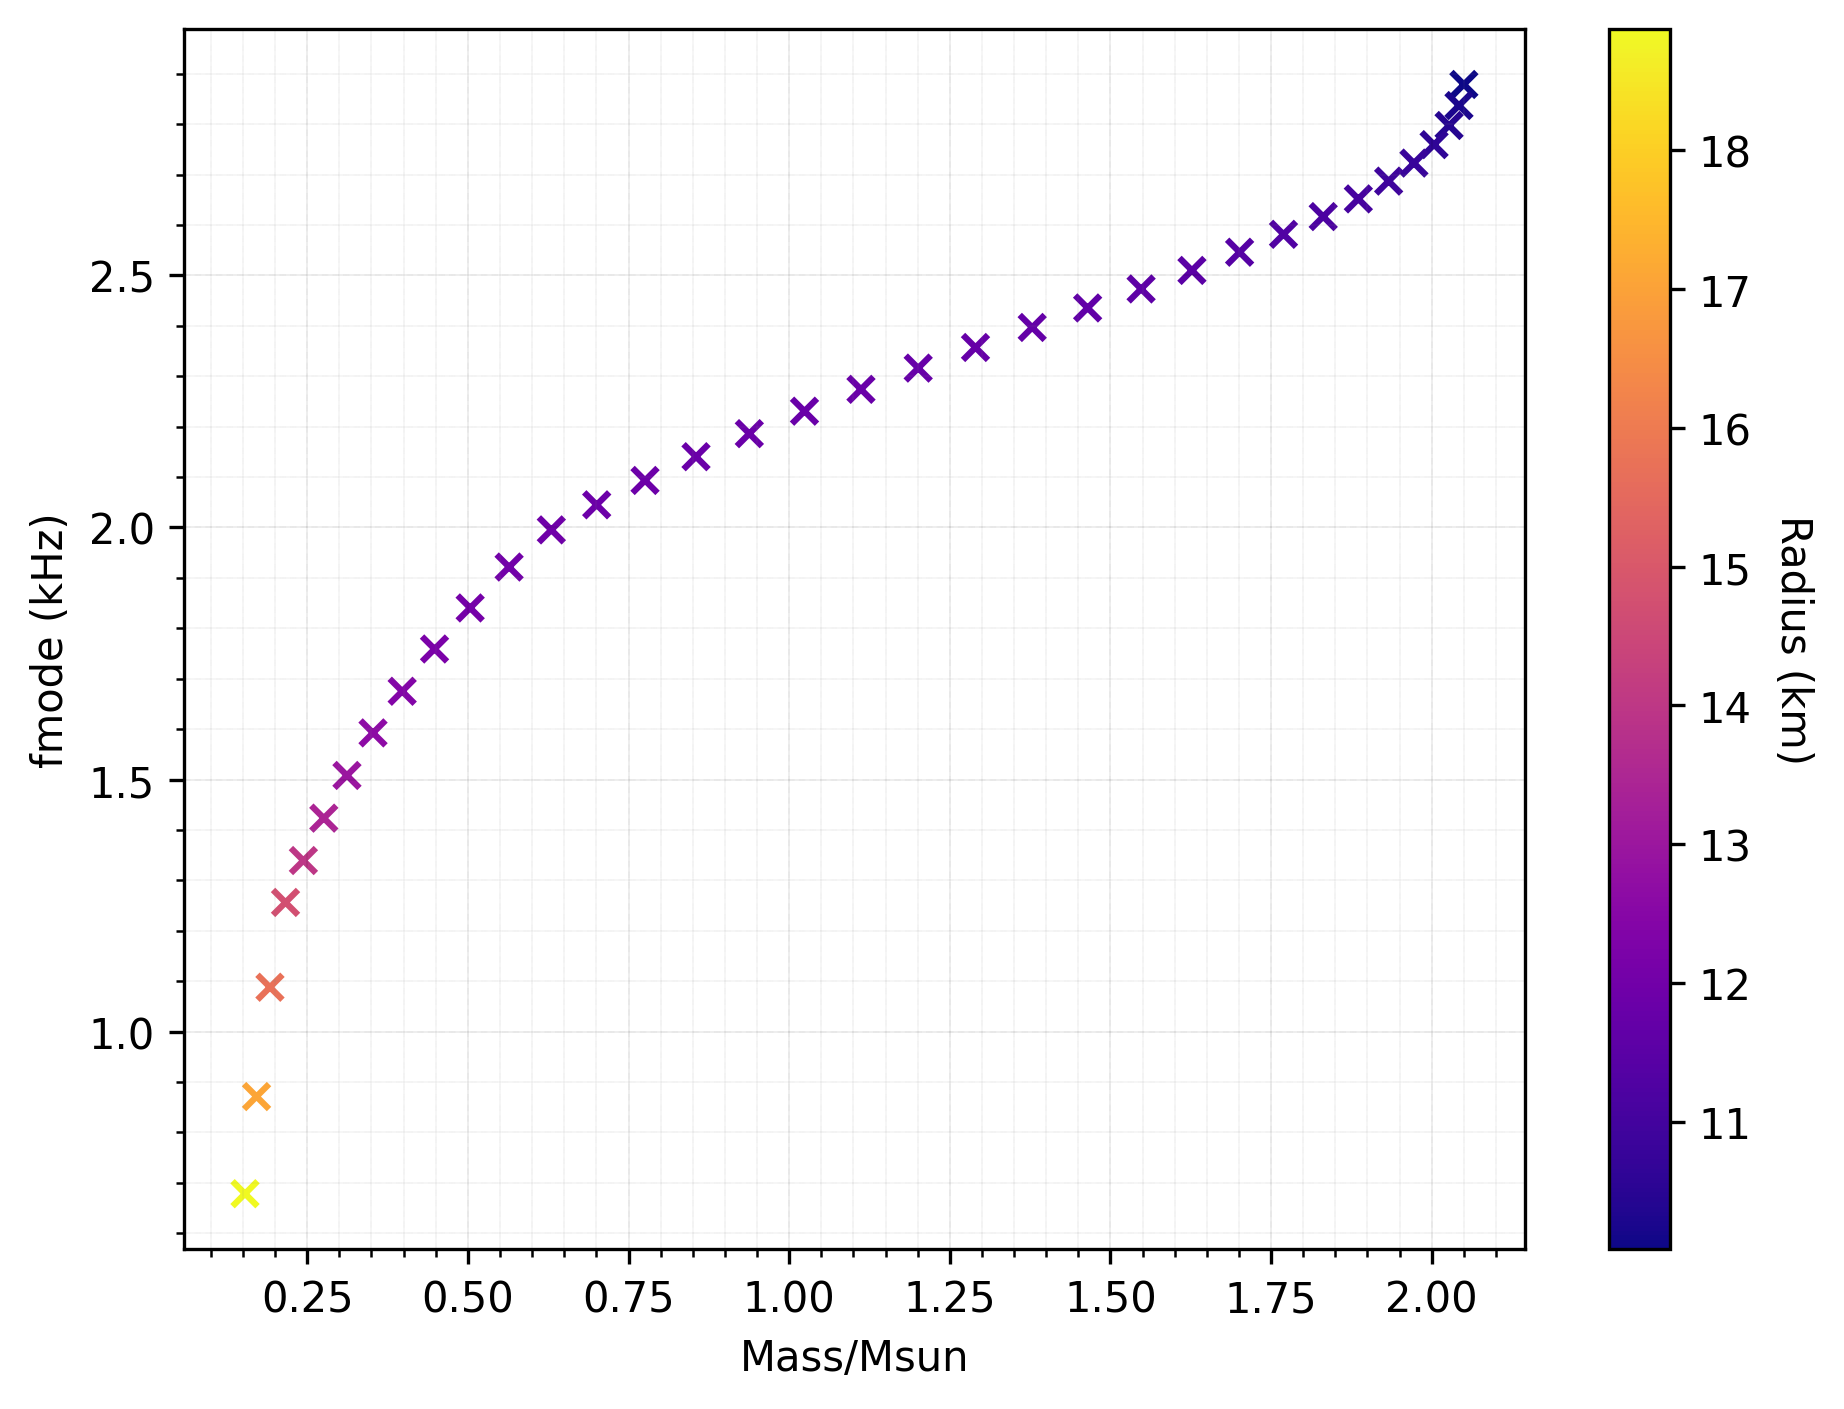

In [9]:
# mass_arr = np.array(mass_list)
# f_mode_arr = np.array(f_mode_list)
# radius_arr = np.array(radius_list)
# hz2khz = 1e-3

plt.figure(dpi = 300)
plt.tight_layout()
plt.scatter(mass_arr/msun, f_mode_arr*hz2khz, c = radius_arr/km2cm, marker = "x", 
            cmap = "plasma")
plt.xlabel("Mass/Msun")
plt.ylabel("fmode (kHz)")
cbar = plt.colorbar()
cbar.set_label('Radius (km)', rotation=-90, labelpad=15)
utkarshGrid()
# plt.xlim(1, 2.5)
# plt.ylim(1.5, 3.5)
plt.show()

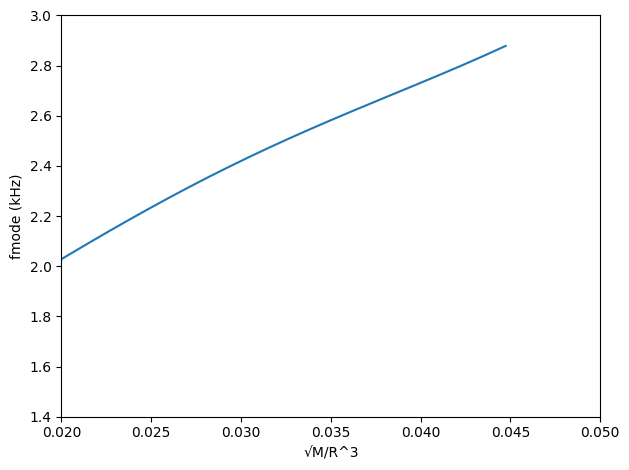

In [10]:
plt.plot(np.sqrt((mass_arr/msun)/((radius_arr/km2cm)**3)), f_mode_arr*hz2khz)
plt.xlabel("√M/R^3")
plt.ylabel("fmode (kHz)")
plt.xlim(0.02, 0.05)
plt.ylim(1.4, 3)
plt.show()

In [11]:
# plt.plot(np.sqrt((mass_arr/(1.4*msun))/((radius_arr/(10*km2cm))**3)), f_mode_arr*hz2khz)
# plt.ylabel("f(khz)")
# plt.show()

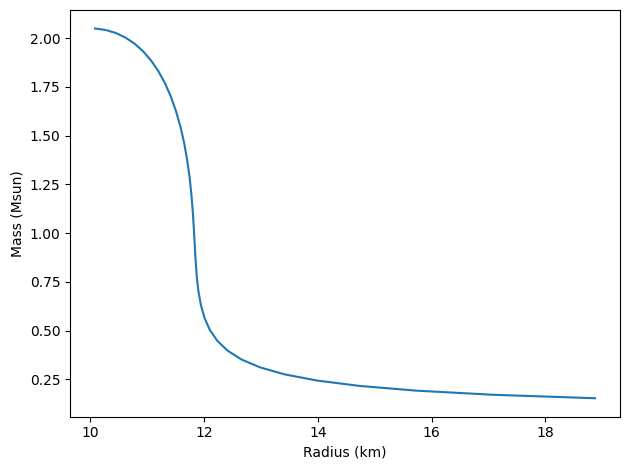

In [12]:
plt.plot(radius_arr/km2cm, mass_arr/msun)
plt.xlabel("Radius (km)")
plt.ylabel("Mass (Msun)")
plt.show()

In [13]:
# np.savetxt("mr_sly.csv", np.array([radius_arr, mass_arr]).T)